# import libraries

In [2]:
import numpy
import xarray
import matplotlib
import matplotlib.pyplot as mp
import datetime
import matplotlib.colors
import scipy.stats
import itertools
import string
import matplotlib.patches
import glob
import matplotlib.gridspec
import cmocean

import wrf
import netCDF4

import pandas

import matplotlib.ticker
import cartopy.mpl.gridliner #import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import mpl_toolkits
import cartopy
import cartopy.io.shapereader

DEGREE_SIGN = u'\u00B0'
mp.rcParams.update({'mathtext.default': 'regular'})

% matplotlib inline

/export/home/blangenb/anaconda3/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [3]:
run_info = 'FMAASO'
skip_time=0

# opening mean fields

## control data

In [4]:
root_dir = '/beegfs/DATA/pritchard/blangenb/WRF_ARCHIVE/CHEYENNE/FMAASO/400/ens_mean_wrfout_files'
file_list = sorted(glob.glob(root_dir+'/'+'wrfout*.nc'))
ds_list = [netCDF4.Dataset(file) for file in file_list]

In [9]:
ptot_400 = numpy.load('DATA_ptot_400.npy')
wa_400 = numpy.load('DATA_wa_400.npy')
#ua_400 = numpy.load('DATA_ua_400.npy')
#va_400 = numpy.load('DATA_va_400.npy')
#tk_400 = numpy.load('DATA_tk_400.npy')
#prw_400 = numpy.load('DATA_prw_400.npy')

geopot_400 = numpy.load('DATA_geopot_400.npy')

In [10]:
cont_mfds = xarray.open_mfdataset(root_dir + '/' + 'wrfout*.nc')

In [11]:
time = cont_mfds['Times'].values
xlat = cont_mfds['XLAT'].values[0,:,:]
xlong = cont_mfds['XLONG'].values[0,:,:]
landmask = cont_mfds['LANDMASK'].values[0,:,:]
landmask_midpoints = landmask[1:,1:]

In [12]:
qvapor_400 = cont_mfds['QVAPOR']
u_400 = cont_mfds['U']
v_400 = cont_mfds['V']
w_400 = cont_mfds['W']
qcloud_400 = cont_mfds['QCLOUD']
qrain_400 = cont_mfds['QRAIN']

In [13]:
rainc_400 = cont_mfds['RAINC']
rainnc_400 = cont_mfds['RAINNC']

## phys data

In [85]:
root_dir = '/beegfs/DATA/pritchard/blangenb/WRF_ARCHIVE/CHEYENNE/FMAASO/1000/ens_mean_wrfout_files'
file_list = sorted(glob.glob(root_dir+'/'+'wrfout*.nc'))
ds_list = [netCDF4.Dataset(file) for file in file_list]

In [ ]:
ptot_1000 = numpy.load('DATA_ptot_1000.npy')
wa_1000 = numpy.load('DATA_wa_1000.npy')
#ua_1000 = numpy.load('DATA_ua_1000.npy')
#va_1000 = numpy.load('DATA_va_1000.npy')
#tk_1000 = numpy.load('DATA_tk_1000.npy')
#prw_1000 = numpy.load('DATA_prw_1000.npy')



In [79]:
geopot_1000 = numpy.load('DATA_geopot_1000.npy')

In [16]:
phys_mfds = xarray.open_mfdataset(root_dir + '/' + 'wrfout*.nc')

In [17]:
qvapor_1000 = phys_mfds['QVAPOR']
u_1000 = phys_mfds['U']
v_1000 = phys_mfds['V']
w_1000 = phys_mfds['W']
qcloud_1000 = phys_mfds['QCLOUD']
qrain_1000 = phys_mfds['QRAIN']

In [18]:
rainc_1000 = phys_mfds['RAINC']
rainnc_1000 = phys_mfds['RAINNC']

## define dx, dy

In [19]:
dx = 50000. # 50,000 m or 50 km
dy = 50000.

# gravitational constant for geopotential height calculations

In [20]:
g = 9.80665

## get landmask

In [21]:
landmask = cont_mfds['LANDMASK'].sel(Time=0).values

In [22]:
lat_indices = ((xlat<=10)&(xlat>=-5))

# calculate raintot and rain diffs

In [23]:
raintot_accum_1000 = rainnc_1000+rainc_1000

raintot_accum_400 = rainnc_400+rainc_400

raintot_1000 = numpy.diff(raintot_accum_1000, axis=0)
raintot_400 = numpy.diff(raintot_accum_400, axis=0)

In [24]:
raintot_diffs = raintot_1000-raintot_400

raintot_diffs_landmask = numpy.copy(raintot_diffs)
raintot_diffs_landmask[:,landmask==0]=numpy.nan
raintot_diffs_lat_subset = raintot_diffs_landmask[:,lat_indices[:,0],:]
raintot_diffs_latmean = numpy.nanmean(raintot_diffs_lat_subset, axis=1)

/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


In [25]:
raintot_diffs_latmean_day1 = numpy.nanmean(raintot_diffs_latmean[:24,:], axis=0)
raintot_diffs_latmean_day2_10 = numpy.nanmean(raintot_diffs_latmean[24:,:], axis=0)

/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


# calculate w diffs for height-longitude plot

In [28]:
wa_diffs = wa_1000-wa_400

wa_diffs_landmask = numpy.copy(wa_diffs)
wa_diffs_landmask[:,:,landmask==0]=numpy.nan

In [29]:
shapefile_name = cartopy.io.shapereader.natural_earth(resolution='110m',
                                                      category='cultural',
                                                      name='admin_0_countries')

reader = cartopy.io.shapereader.Reader(shapefile_name)
countries = reader.records()
country = next(countries)

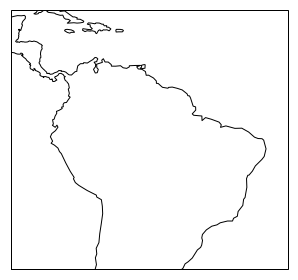

In [30]:
fig, ax = mp.subplots(1,1,subplot_kw={'projection':cartopy.crs.PlateCarree()})
ax.set_extent([270,330,-30,20])
ax.coastlines()
fig.tight_layout()

# calculate midpoints so that fields are 28x178x288

In [31]:
u_400_midpoints = 0.5*(u_400[:,:,:,1:]+u_400[:,:,:,:-1])
u_400_midpoints = 0.5*(u_400_midpoints[:,1:,1:,1:]+u_400_midpoints[:,:-1,:-1,:-1]).values

In [32]:
u_1000_midpoints = 0.5*(u_1000[:,:,:,1:]+u_1000[:,:,:,:-1])
u_1000_midpoints = 0.5*(u_1000_midpoints[:,1:,1:,1:]+u_1000_midpoints[:,:-1,:-1,:-1]).values

In [33]:
v_400_midpoints = 0.5*(v_400[:,:,1:,:]+v_400[:,:,:-1,:])
v_400_midpoints = 0.5*(v_400_midpoints[:,1:,1:,1:]+v_400_midpoints[:,:-1,:-1,:-1]).values

In [34]:
v_1000_midpoints = 0.5*(v_1000[:,:,1:,:]+v_1000[:,:,:-1,:])
v_1000_midpoints = 0.5*(v_1000_midpoints[:,1:,1:,1:]+v_1000_midpoints[:,:-1,:-1,:-1]).values

In [36]:
wa_400_midpoints = (0.5*(wa_400[:,1:,1:,1:]+wa_400[:,:-1,:-1,:-1]))
wa_1000_midpoints = (0.5*(wa_1000[:,1:,1:,1:]+wa_1000[:,:-1,:-1,:-1]))

In [37]:
ptot_400_midpoints = 0.5*(ptot_400[:,1:,1:,1:]+ptot_400[:,:-1,:-1,:-1])
ptot_1000_midpoints = 0.5*(ptot_1000[:,1:,1:,1:]+ptot_1000[:,:-1,:-1,:-1])

In [38]:
geopot_400_midpoints = 0.5*(geopot_400[:,1:,1:,1:]+geopot_400[:,:-1,:-1,:-1])
geopot_1000_midpoints = 0.5*(geopot_1000[:,1:,1:,1:]+geopot_1000[:,:-1,:-1,:-1])

In [39]:
qvapor_400_midpoints = 0.5*(qvapor_400[:,1:,1:,1:]+qvapor_400[:,:-1,:-1,:-1]).values
qvapor_1000_midpoints = 0.5*(qvapor_1000[:,1:,1:,1:]+qvapor_1000[:,:-1,:-1,:-1]).values

In [40]:
qcloud_400_midpoints = 0.5*(qcloud_400[:,1:,1:,1:]+qcloud_400[:,:-1,:-1,:-1]).values
qcloud_1000_midpoints = 0.5*(qcloud_1000[:,1:,1:,1:]+qcloud_1000[:,:-1,:-1,:-1]).values

In [41]:
qrain_400_midpoints = 0.5*(qrain_400[:,1:,1:,1:]+qrain_400[:,:-1,:-1,:-1]).values
qrain_1000_midpoints = 0.5*(qrain_1000[:,1:,1:,1:]+qrain_1000[:,:-1,:-1,:-1]).values

In [42]:
ptot_1000_midpoints = 0.5*(ptot_1000[:,1:,1:,1:]+ptot_1000[:,:-1,:-1,:-1])
ptot_400_midpoints = 0.5*(ptot_400[:,1:,1:,1:]+ptot_400[:,:-1,:-1,:-1])

# calculate dqdt terms

In [43]:
ntime = 241
nlev = 28

dqdt will be automatically placed on midpoints

In [44]:
dqdt_400 = numpy.zeros((ntime,nlev,xlat.shape[0]-1,xlat.shape[1]-1))*numpy.nan
dqdt_1000 = numpy.zeros((ntime,nlev,xlat.shape[0]-1,xlat.shape[1]-1))*numpy.nan

In [45]:
for t in range(1,ntime-1):
    dqdt_400[t,:,:,:] = (qvapor_400_midpoints[t+1,:,:,:]-qvapor_400_midpoints[t-1,:,:,:])/7200.
for t in range(1,ntime-1):
    dqdt_1000[t,:,:,:] = (qvapor_1000_midpoints[t+1,:,:,:]-qvapor_1000_midpoints[t-1,:,:,:])/7200.

## calculate dqcloud dt

In [46]:
dqclouddt_400 = numpy.zeros((ntime,nlev,xlat.shape[0]-1,xlat.shape[1]-1))*numpy.nan
dqclouddt_1000 = numpy.zeros((ntime,nlev,xlat.shape[0]-1,xlat.shape[1]-1))*numpy.nan

In [47]:
for t in range(1,ntime-1):
    dqclouddt_400[t,:,:,:] = (qcloud_400_midpoints[t+1,:,:,:]-qcloud_400_midpoints[t-1,:,:,:])/7200.
for t in range(1,ntime-1):
    dqclouddt_1000[t,:,:,:] = (qcloud_1000_midpoints[t+1,:,:,:]-qcloud_1000_midpoints[t-1,:,:,:])/7200.

## calculate dqraindt

In [48]:
dqraindt_400 = numpy.zeros((ntime,nlev,xlat.shape[0]-1,xlat.shape[1]-1))*numpy.nan
dqraindt_1000 = numpy.zeros((ntime,nlev,xlat.shape[0]-1,xlat.shape[1]-1))*numpy.nan

In [49]:
for t in range(1,ntime-1):
    dqraindt_400[t,:,:,:] = (qrain_400_midpoints[t+1,:,:,:]-qrain_400_midpoints[t-1,:,:,:])/7200.
for t in range(1,ntime-1):
    dqraindt_1000[t,:,:,:] = (qrain_1000_midpoints[t+1,:,:,:]-qrain_1000_midpoints[t-1,:,:,:])/7200.

# calculate convergence terms

In [50]:
dudx_400 = numpy.diff(u_400.values, axis=3)/dx
dudx_400 = 0.5*(dudx_400[:,1:,1:,1:]+dudx_400[:,:-1,:-1,:-1])

In [51]:
dudx_1000 = numpy.diff(u_1000.values, axis=3)/dx
dudx_1000 = 0.5*(dudx_1000[:,1:,1:,1:]+dudx_1000[:,:-1,:-1,:-1])

In [52]:
dvdy_400 = numpy.diff(v_400.values, axis=2)/dy
dvdy_400 = 0.5*(dvdy_400[:,1:,1:,1:]+dvdy_400[:,:-1,:-1,:-1])

In [53]:
dvdy_1000 = numpy.diff(v_1000.values, axis=2)/dy
dvdy_1000 = 0.5*(dvdy_1000[:,1:,1:,1:]+dvdy_1000[:,:-1,:-1,:-1])

In [54]:
ptot_400_diff = numpy.diff(ptot_400, axis=1)
ptot_1000_diff = numpy.diff(ptot_1000, axis=1)

In [88]:
geopot_400_diff = numpy.diff(geopot_400, axis=1) # needed for convergence calculation
geopot_1000_diff = numpy.diff(geopot_1000, axis=1)

In [89]:
geopot_stag_400_diff = numpy.diff(geopot_stag_400, axis=1) # needed for advection calculation
geopot_stag_1000_diff = numpy.diff(geopot_stag_1000, axis=1)

In [90]:
dwdz_400 = numpy.diff(w_400, axis=1)/(geopot_stag_400_diff/g)
dwdz_400 = 0.5*(dwdz_400[:,1:,1:,1:]+dwdz_400[:,:-1,:-1,:-1])

dwdz_1000 = numpy.diff(w_1000, axis=1)/(geopot_stag_1000_diff/g)
dwdz_1000 = 0.5*(dwdz_1000[:,1:,1:,1:]+dwdz_1000[:,:-1,:-1,:-1])

pressure coords

In [65]:
convergence_400 = -qvapor_400_midpoints*(dudx_400 + dvdy_400 + dwdz_400)
convergence_1000 = -qvapor_1000_midpoints*(dudx_1000 + dvdy_1000 + dwdz_1000)

calculate vertical and horizontal terms separately

In [66]:
convergence_400_vert = -qvapor_400_midpoints*dwdz_400 #cont_domegadp
convergence_400_horiz = -qvapor_400_midpoints*(dudx_400 + dvdy_400)

convergence_1000_vert = -qvapor_1000_midpoints*dwdz_1000 #phys_domegadp
convergence_1000_horiz = -qvapor_1000_midpoints*(dudx_1000 + dvdy_1000)

# calculate advection terms

In [67]:
cont_dqdx = numpy.diff(qvapor_400.values, axis=3)/dx # diff in y, then take mean 
cont_dqdx = 0.5*(cont_dqdx[:,1:,1:,:]+cont_dqdx[:,:-1,:-1,:])

In [68]:
phys_dqdx = numpy.diff(qvapor_1000.values, axis=3)/dx # diff in y, then take mean 
phys_dqdx = 0.5*(phys_dqdx[:,1:,1:,:]+phys_dqdx[:,:-1,:-1,:])

In [69]:
cont_dqdy = numpy.diff(qvapor_400.values, axis=2)/dy # diff in y, then take mean 
cont_dqdy = 0.5*(cont_dqdy[:,1:,:,1:]+cont_dqdy[:,:-1,:,:-1])

In [70]:
phys_dqdy = numpy.diff(qvapor_1000.values, axis=2)/dy # diff in y, then take mean 
phys_dqdy = 0.5*(phys_dqdy[:,1:,:,1:]+phys_dqdy[:,:-1,:,:-1])

In [71]:
cont_dqdz = numpy.diff(qvapor_400.values, axis=1)/(geopot_400_diff/g)
cont_dqdz = 0.5*(cont_dqdz[:,:,1:,1:]+cont_dqdz[:,:,:-1,:-1])

In [91]:
phys_dqdz = numpy.diff(qvapor_1000.values, axis=1)/(geopot_1000_diff/g)
phys_dqdz = 0.5*(phys_dqdz[:,:,1:,1:]+phys_dqdz[:,:,:-1,:-1])

In [92]:
advection_400 = -(u_400_midpoints*cont_dqdx + v_400_midpoints*cont_dqdy + wa_400_midpoints*cont_dqdz)
advection_1000 = -(u_1000_midpoints*phys_dqdx + v_1000_midpoints*phys_dqdy + wa_1000_midpoints*phys_dqdz)

for pressure terms

calculate vertical and horizontal terms separately

In [93]:
advection_400_vert = -wa_400_midpoints*cont_dqdz
advection_400_horiz = -(u_400_midpoints*cont_dqdx + v_400_midpoints*cont_dqdy)

advection_1000_vert = -wa_1000_midpoints*phys_dqdz
advection_1000_horiz = -(u_1000_midpoints*phys_dqdx + v_1000_midpoints*phys_dqdy)

# set ocean points to nan

# calculate time means

Only time mean for qcloud, qrain, ptot

Rest have day1 mean as well

In [94]:
dqclouddt_400_tm = numpy.nanmean(dqclouddt_400[24:,:,:,:], axis=0)
dqclouddt_1000_tm = numpy.nanmean(dqclouddt_1000[24:,:,:,:], axis=0)

dqraindt_400_tm = numpy.nanmean(dqraindt_400[24:,:,:,:], axis=0)
dqraindt_1000_tm = numpy.nanmean(dqraindt_1000[24:,:,:,:], axis=0)

ptot_400_tm = numpy.nanmean(ptot_400[24:,:,:,:], axis=0)
ptot_1000_tm = numpy.nanmean(ptot_1000[24:,:,:,:], axis=0)

In [95]:
dqdt_400_tm = numpy.nanmean(dqdt_400[24:,:,:,:], axis=0)
dqdt_1000_tm = numpy.nanmean(dqdt_1000[24:,:,:,:], axis=0)

dqdt_400_tm_day1 = numpy.nanmean(dqdt_400[:24,:,:,:], axis=0)
dqdt_1000_tm_day1 = numpy.nanmean(dqdt_1000[:24,:,:,:], axis=0)

In [96]:
advection_400_tm = numpy.nanmean(advection_400[24:,:,:,:], axis=0)
advection_1000_tm = numpy.nanmean(advection_1000[24:,:,:,:], axis=0)

advection_400_tm_day1 = numpy.nanmean(advection_400[:24,:,:,:], axis=0)
advection_1000_tm_day1 = numpy.nanmean(advection_1000[:24,:,:,:], axis=0)

In [97]:
convergence_400_tm = numpy.nanmean(convergence_400[24:,:,:,:], axis=0)
convergence_1000_tm = numpy.nanmean(convergence_1000[24:,:,:,:], axis=0)

convergence_400_tm_day1 = numpy.nanmean(convergence_400[:24,:,:,:], axis=0)
convergence_1000_tm_day1 = numpy.nanmean(convergence_1000[:24,:,:,:], axis=0)

In [99]:
convergence_400_tm = numpy.nanmean(convergence_400[24:,:,:,:], axis=0)
convergence_1000_tm = numpy.nanmean(convergence_1000[24:,:,:,:], axis=0)

convergence_400_tm_day1 = numpy.nanmean(convergence_400[:24,:,:,:], axis=0)
convergence_1000_tm_day1 = numpy.nanmean(convergence_1000[:24,:,:,:], axis=0)

calculate vertical and horizontal advection terms

In [100]:
advection_400_vert_tm = numpy.nanmean(advection_400_vert[24:,:,:,:], axis=0)
advection_1000_vert_tm = numpy.nanmean(advection_1000_vert[24:,:,:,:], axis=0)
advection_400_vert_tm_day1 = numpy.nanmean(advection_400_vert[:24,:,:,:], axis=0)
advection_1000_vert_tm_day1 = numpy.nanmean(advection_1000_vert[:24,:,:,:], axis=0)

advection_400_horiz_tm = numpy.nanmean(advection_400_horiz[24:,:,:,:], axis=0)
advection_1000_horiz_tm = numpy.nanmean(advection_1000_horiz[24:,:,:,:], axis=0)
advection_400_horiz_tm_day1 = numpy.nanmean(advection_400_horiz[:24,:,:,:], axis=0)
advection_1000_horiz_tm_day1 = numpy.nanmean(advection_1000_horiz[:24,:,:,:], axis=0)

In [101]:
convergence_400_vert_tm = numpy.nanmean(convergence_400_vert[24:,:,:,:], axis=0)
convergence_1000_vert_tm = numpy.nanmean(convergence_1000_vert[24:,:,:,:], axis=0)
convergence_400_vert_tm_day1 = numpy.nanmean(convergence_400_vert[:24,:,:,:], axis=0)
convergence_1000_vert_tm_day1 = numpy.nanmean(convergence_1000_vert[:24,:,:,:], axis=0)

convergence_400_horiz_tm = numpy.nanmean(convergence_400_horiz[24:,:,:,:], axis=0)
convergence_1000_horiz_tm = numpy.nanmean(convergence_1000_horiz[24:,:,:,:], axis=0)
convergence_400_horiz_tm_day1 = numpy.nanmean(convergence_400_horiz[:24,:,:,:], axis=0)
convergence_1000_horiz_tm_day1 = numpy.nanmean(convergence_1000_horiz[:24,:,:,:], axis=0)

In [102]:
#dry_lon_lo, dry_lon_hi, dry_lat_lo, dry_lat_hi = -60,-50,-10,10
#wet_lon_lo, wet_lon_hi, wet_lat_lo, wet_lat_hi = -80,-75,-10,10

dry_lon_lo, dry_lon_hi, dry_lat_lo, dry_lat_hi = -60,-50,-5,10
wet_lon_lo, wet_lon_hi, wet_lat_lo, wet_lat_hi = -80,-70,-5,10

#dry_lon_lo, dry_lon_hi, dry_lat_lo, dry_lat_hi = -65,-50,-10,10
#wet_lon_lo, wet_lon_hi, wet_lat_lo, wet_lat_hi = -80,-75,-10,10

dry_lon_lo_degE = 360+dry_lon_lo
dry_lon_hi_degE = 360+dry_lon_hi

wet_lon_lo_degE = 360+wet_lon_lo
wet_lon_hi_degE = 360+wet_lon_hi

In [103]:
xlat_midpoints = 0.5*(xlat[1:,1:]+xlat[:-1,:-1])
xlong_midpoints = 0.5*(xlong[1:,1:]+xlong[:-1,:-1])

In [104]:
wet_latlon_subset_midpoints = ((xlat_midpoints<=wet_lat_hi) & (xlat_midpoints>=wet_lat_lo) \
                               & (xlong_midpoints<=wet_lon_hi) & (xlong_midpoints>=wet_lon_lo))

dry_latlon_subset_midpoints = ((xlat_midpoints<=dry_lat_hi) & (xlat_midpoints>=dry_lat_lo) \
                               & (xlong_midpoints<=dry_lon_hi) & (xlong_midpoints>=dry_lon_lo))

lat_indices_midpoints = ((xlat_midpoints<=10)&(xlat_midpoints>=-10))

In [105]:
wet_latlon_subset = ((xlat<=wet_lat_hi) & (xlat>=wet_lat_lo) \
                               & (xlong<=wet_lon_hi) & (xlong>=wet_lon_lo))

dry_latlon_subset = ((xlat<=dry_lat_hi) & (xlat>=dry_lat_lo) \
                               & (xlong<=dry_lon_hi) & (xlong>=dry_lon_lo))

lat_indices = ((xlat<=10)&(xlat>=-10))

# pulling out wet and dry regions

In [106]:
dqdt_400_wet_region = numpy.nanmean(dqdt_400_tm[:,wet_latlon_subset_midpoints], axis=1)
dqdt_400_dry_region = numpy.nanmean(dqdt_400_tm[:,dry_latlon_subset_midpoints], axis=1)

dqdt_1000_wet_region = numpy.nanmean(dqdt_1000_tm[:,wet_latlon_subset_midpoints], axis=1)
dqdt_1000_dry_region = numpy.nanmean(dqdt_1000_tm[:,dry_latlon_subset_midpoints], axis=1)

dqdt_400_wet_region_day1 = numpy.nanmean(dqdt_400_tm_day1[:,wet_latlon_subset_midpoints], axis=1)
dqdt_400_dry_region_day1 = numpy.nanmean(dqdt_400_tm_day1[:,dry_latlon_subset_midpoints], axis=1)

dqdt_1000_wet_region_day1 = numpy.nanmean(dqdt_1000_tm_day1[:,wet_latlon_subset_midpoints], axis=1)
dqdt_1000_dry_region_day1 = numpy.nanmean(dqdt_1000_tm_day1[:,dry_latlon_subset_midpoints], axis=1)

In [107]:
convergence_400_wet_region = numpy.nanmean(convergence_400_tm[:,wet_latlon_subset_midpoints], axis=1)
convergence_400_dry_region = numpy.nanmean(convergence_400_tm[:,dry_latlon_subset_midpoints], axis=1)

convergence_1000_wet_region = numpy.nanmean(convergence_1000_tm[:,wet_latlon_subset_midpoints], axis=1)
convergence_1000_dry_region = numpy.nanmean(convergence_1000_tm[:,dry_latlon_subset_midpoints], axis=1)

convergence_400_wet_region_day1 = numpy.nanmean(convergence_400_tm_day1[:,wet_latlon_subset_midpoints], axis=1)
convergence_400_dry_region_day1 = numpy.nanmean(convergence_400_tm_day1[:,dry_latlon_subset_midpoints], axis=1)

convergence_1000_wet_region_day1 = numpy.nanmean(convergence_1000_tm_day1[:,wet_latlon_subset_midpoints], axis=1)
convergence_1000_dry_region_day1 = numpy.nanmean(convergence_1000_tm_day1[:,dry_latlon_subset_midpoints], axis=1)

In [108]:
advection_400_wet_region = numpy.nanmean(advection_400_tm[:,wet_latlon_subset_midpoints], axis=1)
advection_400_dry_region = numpy.nanmean(advection_400_tm[:,dry_latlon_subset_midpoints], axis=1)

advection_1000_wet_region = numpy.nanmean(advection_1000_tm[:,wet_latlon_subset_midpoints], axis=1)
advection_1000_dry_region = numpy.nanmean(advection_1000_tm[:,dry_latlon_subset_midpoints], axis=1)

advection_400_wet_region_day1 = numpy.nanmean(advection_400_tm_day1[:,wet_latlon_subset_midpoints], axis=1)
advection_400_dry_region_day1 = numpy.nanmean(advection_400_tm_day1[:,dry_latlon_subset_midpoints], axis=1)

advection_1000_wet_region_day1 = numpy.nanmean(advection_1000_tm_day1[:,wet_latlon_subset_midpoints], axis=1)
advection_1000_dry_region_day1 = numpy.nanmean(advection_1000_tm_day1[:,dry_latlon_subset_midpoints], axis=1)

In [109]:
wa_400_tm = numpy.nanmean(wa_400[24:,:,:,:], axis=0)
wa_1000_tm = numpy.nanmean(wa_1000[24:,:,:,:], axis=0)

wa_400_tm_day1 = numpy.nanmean(wa_400[:24,:,:,:], axis=0)
wa_1000_tm_day1 = numpy.nanmean(wa_1000[:24,:,:,:], axis=0)

In [110]:
wa_400_wet = numpy.nanmean(wa_400_tm[:,wet_latlon_subset],axis=1)
wa_400_dry = numpy.nanmean(wa_400_tm[:,dry_latlon_subset],axis=1)

wa_1000_wet = numpy.nanmean(wa_1000_tm[:,wet_latlon_subset],axis=1)
wa_1000_dry = numpy.nanmean(wa_1000_tm[:,dry_latlon_subset],axis=1)

wa_400_wet_day1 = numpy.nanmean(wa_400_tm_day1[:,wet_latlon_subset],axis=1)
wa_400_dry_day1 = numpy.nanmean(wa_400_tm_day1[:,dry_latlon_subset],axis=1)

wa_1000_wet_day1 = numpy.nanmean(wa_1000_tm_day1[:,wet_latlon_subset],axis=1)
wa_1000_dry_day1 = numpy.nanmean(wa_1000_tm_day1[:,dry_latlon_subset],axis=1)

In [112]:
convergence_400_vert_wet_region = numpy.nanmean(convergence_400_vert_tm[:,wet_latlon_subset_midpoints], axis=1)
convergence_400_vert_dry_region = numpy.nanmean(convergence_400_vert_tm[:,dry_latlon_subset_midpoints], axis=1)

convergence_1000_vert_wet_region = numpy.nanmean(convergence_1000_vert_tm[:,wet_latlon_subset_midpoints], axis=1)
convergence_1000_vert_dry_region = numpy.nanmean(convergence_1000_vert_tm[:,dry_latlon_subset_midpoints], axis=1)

convergence_400_vert_wet_region_day1 = numpy.nanmean(convergence_400_vert_tm_day1[:,wet_latlon_subset_midpoints], axis=1)
convergence_400_vert_dry_region_day1 = numpy.nanmean(convergence_400_vert_tm_day1[:,dry_latlon_subset_midpoints], axis=1)

convergence_1000_vert_wet_region_day1 = numpy.nanmean(convergence_1000_vert_tm_day1[:,wet_latlon_subset_midpoints], axis=1)
convergence_1000_vert_dry_region_day1 = numpy.nanmean(convergence_1000_vert_tm_day1[:,dry_latlon_subset_midpoints], axis=1)



In [113]:
convergence_400_horiz_wet_region = numpy.nanmean(convergence_400_horiz_tm[:,wet_latlon_subset_midpoints], axis=1)
convergence_400_horiz_dry_region = numpy.nanmean(convergence_400_horiz_tm[:,dry_latlon_subset_midpoints], axis=1)

convergence_1000_horiz_wet_region = numpy.nanmean(convergence_1000_horiz_tm[:,wet_latlon_subset_midpoints], axis=1)
convergence_1000_horiz_dry_region = numpy.nanmean(convergence_1000_horiz_tm[:,dry_latlon_subset_midpoints], axis=1)

convergence_400_horiz_wet_region_day1 = numpy.nanmean(convergence_400_horiz_tm_day1[:,wet_latlon_subset_midpoints], axis=1)
convergence_400_horiz_dry_region_day1 = numpy.nanmean(convergence_400_horiz_tm_day1[:,dry_latlon_subset_midpoints], axis=1)

convergence_1000_horiz_wet_region_day1 = numpy.nanmean(convergence_1000_horiz_tm_day1[:,wet_latlon_subset_midpoints], axis=1)
convergence_1000_horiz_dry_region_day1 = numpy.nanmean(convergence_1000_horiz_tm_day1[:,dry_latlon_subset_midpoints], axis=1)



In [114]:
advection_400_vert_wet_region = numpy.nanmean(advection_400_vert_tm[:,wet_latlon_subset_midpoints], axis=1)
advection_400_vert_dry_region = numpy.nanmean(advection_400_vert_tm[:,dry_latlon_subset_midpoints], axis=1)

advection_1000_vert_wet_region = numpy.nanmean(advection_1000_vert_tm[:,wet_latlon_subset_midpoints], axis=1)
advection_1000_vert_dry_region = numpy.nanmean(advection_1000_vert_tm[:,dry_latlon_subset_midpoints], axis=1)

advection_400_vert_wet_region_day1 = numpy.nanmean(advection_400_vert_tm_day1[:,wet_latlon_subset_midpoints], axis=1)
advection_400_vert_dry_region_day1 = numpy.nanmean(advection_400_vert_tm_day1[:,dry_latlon_subset_midpoints], axis=1)

advection_1000_vert_wet_region_day1 = numpy.nanmean(advection_1000_vert_tm_day1[:,wet_latlon_subset_midpoints], axis=1)
advection_1000_vert_dry_region_day1 = numpy.nanmean(advection_1000_vert_tm_day1[:,dry_latlon_subset_midpoints], axis=1)

In [115]:
advection_400_horiz_wet_region = numpy.nanmean(advection_400_horiz_tm[:,wet_latlon_subset_midpoints], axis=1)
advection_400_horiz_dry_region = numpy.nanmean(advection_400_horiz_tm[:,dry_latlon_subset_midpoints], axis=1)

advection_1000_horiz_wet_region = numpy.nanmean(advection_1000_horiz_tm[:,wet_latlon_subset_midpoints], axis=1)
advection_1000_horiz_dry_region = numpy.nanmean(advection_1000_horiz_tm[:,dry_latlon_subset_midpoints], axis=1)

advection_400_horiz_wet_region_day1 = numpy.nanmean(advection_400_horiz_tm_day1[:,wet_latlon_subset_midpoints], axis=1)
advection_400_horiz_dry_region_day1 = numpy.nanmean(advection_400_horiz_tm_day1[:,dry_latlon_subset_midpoints], axis=1)

advection_1000_horiz_wet_region_day1 = numpy.nanmean(advection_1000_horiz_tm_day1[:,wet_latlon_subset_midpoints], axis=1)
advection_1000_horiz_dry_region_day1 = numpy.nanmean(advection_1000_horiz_tm_day1[:,dry_latlon_subset_midpoints], axis=1)

# plot vertical changes using ptot change

In [116]:
ptot_400_dry_region_midpoints = numpy.nanmean(ptot_400_midpoints[:,:,dry_latlon_subset_midpoints], axis=(0,2))
ptot_400_wet_region_midpoints = numpy.nanmean(ptot_400_midpoints[:,:,wet_latlon_subset_midpoints], axis=(0,2))

In [117]:
ptot_400_dry_region = numpy.nanmean(ptot_400[:,:,dry_latlon_subset], axis=(0,2))
ptot_400_wet_region = numpy.nanmean(ptot_400[:,:,wet_latlon_subset], axis=(0,2))

In [118]:
diff_wet_region_dqdt = dqdt_1000_wet_region-dqdt_400_wet_region
diff_dry_region_dqdt = dqdt_1000_dry_region-dqdt_400_dry_region

diff_wet_region_dqdt_day1 = dqdt_1000_wet_region_day1-dqdt_400_wet_region_day1
diff_dry_region_dqdt_day1 = dqdt_1000_dry_region_day1-dqdt_400_dry_region_day1

In [119]:
diff_wet_region_conv = convergence_1000_wet_region-convergence_400_wet_region
diff_dry_region_conv = convergence_1000_dry_region-convergence_400_dry_region

diff_wet_region_conv_day1 = convergence_1000_wet_region_day1-convergence_400_wet_region_day1
diff_dry_region_conv_day1 = convergence_1000_dry_region_day1-convergence_400_dry_region_day1

In [120]:
diff_wet_region_adv = advection_1000_wet_region-advection_400_wet_region
diff_dry_region_adv = advection_1000_dry_region-advection_400_dry_region

diff_wet_region_adv_day1 = advection_1000_wet_region_day1-advection_400_wet_region_day1
diff_dry_region_adv_day1 = advection_1000_dry_region_day1-advection_400_dry_region_day1

In [121]:
wa_diff_wet_region = wa_1000_wet-wa_400_wet
wa_diff_dry_region = wa_1000_dry-wa_400_dry

wa_diff_wet_region_day1 = wa_1000_wet_day1-wa_400_wet_day1
wa_diff_dry_region_day1 = wa_1000_dry_day1-wa_400_dry_day1

same but for vert and horiz split up

In [122]:
diff_wet_region_vert_conv = convergence_1000_vert_wet_region-convergence_400_vert_wet_region
diff_dry_region_vert_conv = convergence_1000_vert_dry_region-convergence_400_vert_dry_region

diff_wet_region_vert_conv_day1 = convergence_1000_vert_wet_region_day1-convergence_400_vert_wet_region_day1
diff_dry_region_vert_conv_day1 = convergence_1000_vert_dry_region_day1-convergence_400_vert_dry_region_day1

diff_wet_region_vert_adv = advection_1000_vert_wet_region-advection_400_vert_wet_region
diff_dry_region_vert_adv = advection_1000_vert_dry_region-advection_400_vert_dry_region

diff_wet_region_vert_adv_day1 = advection_1000_vert_wet_region_day1-advection_400_vert_wet_region_day1
diff_dry_region_vert_adv_day1 = advection_1000_vert_dry_region_day1-advection_400_vert_dry_region_day1

In [123]:
diff_wet_region_horiz_conv = convergence_1000_horiz_wet_region-convergence_400_horiz_wet_region
diff_dry_region_horiz_conv = convergence_1000_horiz_dry_region-convergence_400_horiz_dry_region

diff_wet_region_horiz_conv_day1 = convergence_1000_horiz_wet_region_day1-convergence_400_horiz_wet_region_day1
diff_dry_region_horiz_conv_day1 = convergence_1000_horiz_dry_region_day1-convergence_400_horiz_dry_region_day1

diff_wet_region_horiz_adv = advection_1000_horiz_wet_region-advection_400_horiz_wet_region
diff_dry_region_horiz_adv = advection_1000_horiz_dry_region-advection_400_horiz_dry_region

diff_wet_region_horiz_adv_day1 = advection_1000_horiz_wet_region_day1-advection_400_horiz_wet_region_day1
diff_dry_region_horiz_adv_day1 = advection_1000_horiz_dry_region_day1-advection_400_horiz_dry_region_day1

# plot vertical profiles of changes in moisture advection (total)

# plot climatological moisture advection/convergence

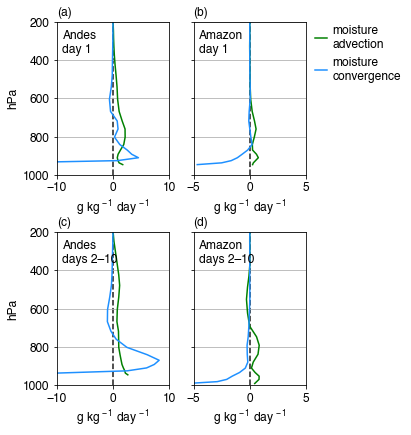

In [124]:
fontsize=12

fig = mp.figure(figsize=(4.5,6))

ax_list = []

#####
ax = fig.add_subplot(221)

ax.plot(advection_400_wet_region_day1*1000.*86400.,ptot_400_wet_region_midpoints/100., c='green', label='moist. adv.')
ax.plot(convergence_400_wet_region_day1*1000.*86400.,ptot_400_wet_region_midpoints/100., c='dodgerblue', label='moist. conv.')
#ax.plot(diff_wet_region_dqdt_day1*1000.*86400.,ptot_400_wet_region_midpoints/100., c='0.5', label='dq/dt')
ax.axvline(0, ls='--', c='0.1', zorder=1)
#ax.axhline(860, ls='--', c='0.1')
ax.set_ylim(1000,200)
ax.set_xlim(-10,10)
ax.tick_params(labelsize=fontsize)
ax.set_xlabel('g kg$^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)
ax.set_ylabel('hPa', fontsize=fontsize)
ax.text(s='Andes\nday 1', x=0.05, y=0.95, ha='left', va='top', transform=ax.transAxes, fontsize=fontsize)
ax.text(s='(a)', x=0, y=1.02, ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)
ax.yaxis.grid()
ax_list.append(ax)

#####
ax = fig.add_subplot(222)

ax.plot(advection_400_dry_region_day1*1000.*86400.,ptot_400_wet_region_midpoints/100., c='green', label='moisture\nadvection')
ax.plot(convergence_400_dry_region_day1*1000.*86400.,ptot_400_wet_region_midpoints/100., c='dodgerblue', label='moisture\nconvergence')
#ax.plot(diff_dry_region_dqdt_day1*1000.*86400.,ptot_400_wet_region_midpoints/100., c='0.5', label='dq/dt')
ax.axvline(0, ls='--', c='0.1', zorder=1)
#ax.axhline(860, ls='--', c='0.1')
ax.set_ylim(1000,200)
ax.set_xlim(-5,5)
ax.tick_params(labelsize=fontsize)
ax.set_xlabel('g kg$^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)
ax.set_yticklabels([])
ax_list.append(ax)
#ax.text(s='860\nhPa', x=0.3, y=860, ha='left', va='center', fontsize=fontsize)
ax.text(s='Amazon\nday 1', x=0.05, y=0.95, ha='left', va='top', transform=ax.transAxes, fontsize=fontsize)
ax.text(s='(b)', x=0, y=1.02, ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)
ax.yaxis.grid()

#####
ax = fig.add_subplot(223)

ax.plot(advection_400_wet_region*1000.*86400.,ptot_400_wet_region_midpoints/100., c='green', label='moisture\nadvection')
ax.plot(convergence_400_wet_region*1000.*86400.,ptot_400_wet_region_midpoints/100.,c='dodgerblue', label='moisture\nconvergence')
#ax.plot(diff_wet_region_dqdt*1000.*86400.,ptot_400_wet_region_midpoints/100.,c='0.5', label='dq/dt')
ax.axvline(0, ls='--', c='0.1', zorder=1)
#ax.axhline(860, ls='--', c='0.1')
ax.set_ylim(1000,200)
ax.set_xlim(-10,10)
ax.tick_params(labelsize=fontsize)
ax.set_xlabel('g kg$^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)
ax.set_ylabel('hPa', fontsize=fontsize)
ax.text(s='Andes\ndays 2–10', x=0.05, y=0.95, ha='left', va='top', transform=ax.transAxes, fontsize=fontsize)
ax.text(s='(c)', x=0, y=1.02, ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)
ax.yaxis.grid()
ax_list.append(ax)

#####
ax = fig.add_subplot(224)

ax.plot(advection_400_dry_region*1000.*86400.,ptot_400_dry_region_midpoints/100., c='green', label='moisture\nadvection')
ax.plot(convergence_400_dry_region*1000.*86400.,ptot_400_dry_region_midpoints/100.,c='dodgerblue', label='moisture\nconvergence')
#ax.plot(diff_dry_region_dqdt*1000.*86400.,ptot_400_dry_region_midpoints/100.,c='0.5',label='dq/dt')
ax.axvline(0, ls='--', c='0.1', zorder=1)
#ax.axhline(860, ls='--', c='0.1')
ax.set_ylim(1000,200)
ax.set_xlim(-5,5)
ax.tick_params(labelsize=fontsize)
ax.set_xlabel('g kg$^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)
ax.set_yticklabels([])
#ax.set_ylabel('hPa', fontsize=fontsize)
ax.text(s='Amazon\ndays 2–10', x=0.05, y=0.95, ha='left', va='top', transform=ax.transAxes, fontsize=fontsize)
#ax.text(s='860\nhPa', x=0.3, y=860, ha='left', va='center', fontsize=fontsize)
ax.text(s='(d)', x=0, y=1.02, ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)
ax.yaxis.grid()
ax_list.append(ax)

fig.tight_layout(h_pad=1)

handles, labels = ax_list[1].get_legend_handles_labels()
legend = ax_list[1].legend(handles, labels, fontsize=fontsize, bbox_to_anchor=(1.05,1), edgecolor='None', \
                   facecolor='None', fancybox=False, bbox_transform=ax_list[1].transAxes, loc='upper left', \
                   borderaxespad=0., borderpad=0.25, handlelength=1.0, handletextpad=0.5, \
                   columnspacing=0.5, markerscale=1)

fig.savefig('manuscript_figXX_climatological_moisture_budget_TOTAL_10d_and_day1.png', dpi=600, \
            transparent=True, bbox_inches='tight')


# plot individual conv, div, dqdt terms

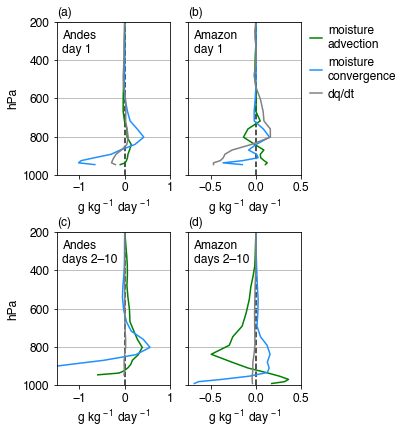

In [125]:
fontsize=12

fig = mp.figure(figsize=(4.5,6))

ax_list = []

#####
ax = fig.add_subplot(221)

ax.plot(diff_wet_region_adv_day1*1000.*86400.,ptot_400_wet_region_midpoints/100., c='green', label='moist. adv.')
ax.plot(diff_wet_region_conv_day1*1000.*86400.,ptot_400_wet_region_midpoints/100., c='dodgerblue', label='moist. conv.')
ax.plot(diff_wet_region_dqdt_day1*1000.*86400.,ptot_400_wet_region_midpoints/100., c='0.5', label='dq/dt')
ax.axvline(0, ls='--', c='0.1', zorder=1)
#ax.axhline(860, ls='--', c='0.1')
ax.set_ylim(1000,200)
ax.set_xlim(-1.5,1)
ax.tick_params(labelsize=fontsize)
ax.set_xlabel('g kg$^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)
ax.set_ylabel('hPa', fontsize=fontsize)
ax.text(s='Andes\nday 1', x=0.05, y=0.95, ha='left', va='top', transform=ax.transAxes, fontsize=fontsize)
ax.text(s='(a)', x=0, y=1.02, ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)
ax.yaxis.grid()
ax_list.append(ax)

#####
ax = fig.add_subplot(222)

ax.plot(diff_dry_region_adv_day1*1000.*86400.,ptot_400_wet_region_midpoints/100., c='green', label='moisture\nadvection')
ax.plot(diff_dry_region_conv_day1*1000.*86400.,ptot_400_wet_region_midpoints/100., c='dodgerblue', label='moisture\nconvergence')
ax.plot(diff_dry_region_dqdt_day1*1000.*86400.,ptot_400_wet_region_midpoints/100., c='0.5', label='dq/dt')
ax.axvline(0, ls='--', c='0.1', zorder=1)
#ax.axhline(860, ls='--', c='0.1')
ax.set_ylim(1000,200)
ax.set_xlim(-0.75,0.5)
ax.tick_params(labelsize=fontsize)
ax.set_xlabel('g kg$^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)
ax.set_yticklabels([])
ax_list.append(ax)
#ax.text(s='860\nhPa', x=0.3, y=860, ha='left', va='center', fontsize=fontsize)
ax.text(s='Amazon\nday 1', x=0.05, y=0.95, ha='left', va='top', transform=ax.transAxes, fontsize=fontsize)
ax.text(s='(b)', x=0, y=1.02, ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)
ax.yaxis.grid()

#####
ax = fig.add_subplot(223)

ax.plot(diff_wet_region_adv*1000.*86400.,ptot_400_wet_region_midpoints/100., c='green', label='moisture\nadvection')
ax.plot(diff_wet_region_conv*1000.*86400.,ptot_400_wet_region_midpoints/100.,c='dodgerblue', label='moisture\nconvergence')
ax.plot(diff_wet_region_dqdt*1000.*86400.,ptot_400_wet_region_midpoints/100.,c='0.5', label='dq/dt')
ax.axvline(0, ls='--', c='0.1', zorder=1)
#ax.axhline(860, ls='--', c='0.1')
ax.set_ylim(1000,200)
ax.set_xlim(-1.5,1)
ax.tick_params(labelsize=fontsize)
ax.set_xlabel('g kg$^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)
ax.set_ylabel('hPa', fontsize=fontsize)
ax.text(s='Andes\ndays 2–10', x=0.05, y=0.95, ha='left', va='top', transform=ax.transAxes, fontsize=fontsize)
ax.text(s='(c)', x=0, y=1.02, ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)
ax.yaxis.grid()
ax_list.append(ax)

#####
ax = fig.add_subplot(224)

ax.plot(diff_dry_region_adv*1000.*86400.,ptot_400_dry_region_midpoints/100., c='green', label='moisture\nadvection')
ax.plot(diff_dry_region_conv*1000.*86400.,ptot_400_dry_region_midpoints/100.,c='dodgerblue', label='moisture\nconvergence')
ax.plot(diff_dry_region_dqdt*1000.*86400.,ptot_400_dry_region_midpoints/100.,c='0.5',label='dq/dt')
ax.axvline(0, ls='--', c='0.1', zorder=1)
#ax.axhline(860, ls='--', c='0.1')
ax.set_ylim(1000,200)
ax.set_xlim(-0.75,0.5)
ax.tick_params(labelsize=fontsize)
ax.set_xlabel('g kg$^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)
ax.set_yticklabels([])
#ax.set_ylabel('hPa', fontsize=fontsize)
ax.text(s='Amazon\ndays 2–10', x=0.05, y=0.95, ha='left', va='top', transform=ax.transAxes, fontsize=fontsize)
#ax.text(s='860\nhPa', x=0.3, y=860, ha='left', va='center', fontsize=fontsize)
ax.text(s='(d)', x=0, y=1.02, ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)
ax.yaxis.grid()
ax_list.append(ax)

fig.tight_layout(h_pad=1)

handles, labels = ax_list[1].get_legend_handles_labels()
legend = ax_list[1].legend(handles, labels, fontsize=fontsize, bbox_to_anchor=(1.05,1), edgecolor='None', \
                   facecolor='None', fancybox=False, bbox_transform=ax_list[1].transAxes, loc='upper left', \
                   borderaxespad=0., borderpad=0.25, handlelength=1.0, handletextpad=0.5, \
                   columnspacing=0.5, markerscale=1)

fig.savefig('manuscript_figXX_mean_moisture_budget_TOTAL_10d_and_day1.png', dpi=600, \
            transparent=True, bbox_inches='tight')

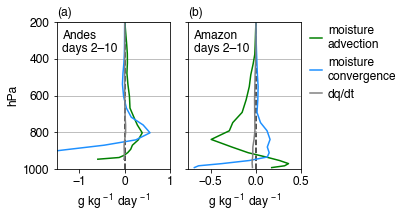

In [126]:
fontsize=12

fig = mp.figure(figsize=(4.5,3))

ax_list = []

#####
ax = fig.add_subplot(121)

ax.plot(diff_wet_region_adv*1000.*86400.,ptot_400_wet_region_midpoints/100., c='green', label='moisture\nadvection')
ax.plot(diff_wet_region_conv*1000.*86400.,ptot_400_wet_region_midpoints/100.,c='dodgerblue', label='moisture\nconvergence')
ax.plot(diff_wet_region_dqdt*1000.*86400.,ptot_400_wet_region_midpoints/100.,c='0.5', label='dq/dt')
ax.axvline(0, ls='--', c='0.1', zorder=1)
#ax.axhline(860, ls='--', c='0.1')
ax.set_ylim(1000,200)
ax.set_xlim(-1.5,1)
ax.tick_params(labelsize=fontsize)
ax.set_xlabel('g kg$^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)
ax.set_ylabel('hPa', fontsize=fontsize)
ax.text(s='Andes\ndays 2–10', x=0.05, y=0.95, ha='left', va='top', transform=ax.transAxes, fontsize=fontsize)
ax.text(s='(a)', x=0, y=1.02, ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)
ax.yaxis.grid()
ax_list.append(ax)

#####
ax = fig.add_subplot(122)

ax.plot(diff_dry_region_adv*1000.*86400.,ptot_400_dry_region_midpoints/100., c='green', label='moisture\nadvection')
ax.plot(diff_dry_region_conv*1000.*86400.,ptot_400_dry_region_midpoints/100.,c='dodgerblue', label='moisture\nconvergence')
ax.plot(diff_dry_region_dqdt*1000.*86400.,ptot_400_dry_region_midpoints/100.,c='0.5',label='dq/dt')
ax.axvline(0, ls='--', c='0.1', zorder=1)
#ax.axhline(860, ls='--', c='0.1')
ax.set_ylim(1000,200)
ax.set_xlim(-0.75,0.5)
ax.tick_params(labelsize=fontsize)
ax.set_xlabel('g kg$^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)
ax.set_yticklabels([])
#ax.set_ylabel('hPa', fontsize=fontsize)
ax.text(s='Amazon\ndays 2–10', x=0.05, y=0.95, ha='left', va='top', transform=ax.transAxes, fontsize=fontsize)
#ax.text(s='860\nhPa', x=0.3, y=860, ha='left', va='center', fontsize=fontsize)
ax.text(s='(b)', x=0, y=1.02, ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)
ax.yaxis.grid()
ax_list.append(ax)

fig.tight_layout(h_pad=1)

handles, labels = ax_list[1].get_legend_handles_labels()
legend = ax_list[1].legend(handles, labels, fontsize=fontsize, bbox_to_anchor=(1.05,1), edgecolor='None', \
                   facecolor='None', fancybox=False, bbox_transform=ax_list[1].transAxes, loc='upper left', \
                   borderaxespad=0., borderpad=0.25, handlelength=1.0, handletextpad=0.5, \
                   columnspacing=0.5, markerscale=1)

fig.savefig('manuscript_figXX_mean_moisture_budget_TOTAL_10d_ONLY.png', dpi=600, \
            transparent=True, bbox_inches='tight')

# Do same for vertical terms

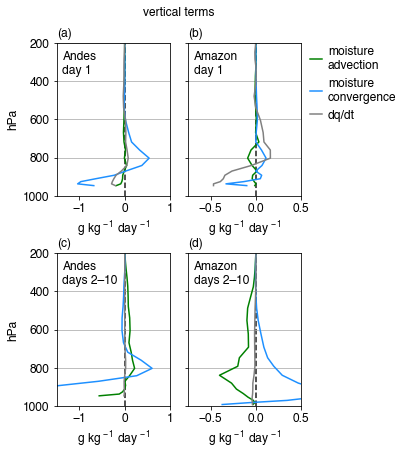

In [127]:
fontsize=12

fig = mp.figure(figsize=(4.5,6))

ax_list = []

#####
ax = fig.add_subplot(221)

ax.plot(diff_wet_region_vert_adv_day1*1000.*86400.,ptot_400_wet_region_midpoints/100., c='green', label='moist. adv.')
ax.plot(diff_wet_region_vert_conv_day1*1000.*86400.,ptot_400_wet_region_midpoints/100., c='dodgerblue', label='moist. conv.')
ax.plot(diff_wet_region_dqdt_day1*1000.*86400.,ptot_400_wet_region_midpoints/100., c='0.5', label='dq/dt')
ax.axvline(0, ls='--', c='0.1', zorder=1)
#ax.axhline(860, ls='--', c='0.1')
ax.set_ylim(1000,200)
ax.set_xlim(-1.5,1)
ax.tick_params(labelsize=fontsize)
ax.set_xlabel('g kg$^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)
ax.set_ylabel('hPa', fontsize=fontsize)
ax.text(s='Andes\nday 1', x=0.05, y=0.95, ha='left', va='top', transform=ax.transAxes, fontsize=fontsize)
ax.text(s='(a)', x=0, y=1.02, ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)
ax.yaxis.grid()
ax_list.append(ax)

#####
ax = fig.add_subplot(222)

ax.plot(diff_dry_region_vert_adv_day1*1000.*86400.,ptot_400_wet_region_midpoints/100., c='green', label='moisture\nadvection')
ax.plot(diff_dry_region_vert_conv_day1*1000.*86400.,ptot_400_wet_region_midpoints/100., c='dodgerblue', label='moisture\nconvergence')
ax.plot(diff_dry_region_dqdt_day1*1000.*86400.,ptot_400_wet_region_midpoints/100., c='0.5', label='dq/dt')
ax.axvline(0, ls='--', c='0.1', zorder=1)
#ax.axhline(860, ls='--', c='0.1')
ax.set_ylim(1000,200)
ax.set_xlim(-0.75,0.5)
ax.tick_params(labelsize=fontsize)
ax.set_xlabel('g kg$^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)
ax.set_yticklabels([])
ax_list.append(ax)
#ax.text(s='860\nhPa', x=0.3, y=860, ha='left', va='center', fontsize=fontsize)
ax.text(s='Amazon\nday 1', x=0.05, y=0.95, ha='left', va='top', transform=ax.transAxes, fontsize=fontsize)
ax.text(s='(b)', x=0, y=1.02, ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)
ax.yaxis.grid()

#####
ax = fig.add_subplot(223)

ax.plot(diff_wet_region_vert_adv*1000.*86400.,ptot_400_wet_region_midpoints/100., c='green', label='moisture\nadvection')
ax.plot(diff_wet_region_vert_conv*1000.*86400.,ptot_400_wet_region_midpoints/100.,c='dodgerblue', label='moisture\nconvergence')
ax.plot(diff_wet_region_dqdt*1000.*86400.,ptot_400_wet_region_midpoints/100.,c='0.5', label='dq/dt')
ax.axvline(0, ls='--', c='0.1', zorder=1)
#ax.axhline(860, ls='--', c='0.1')
ax.set_ylim(1000,200)
ax.set_xlim(-1.5,1)
ax.tick_params(labelsize=fontsize)
ax.set_xlabel('g kg$^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)
ax.set_ylabel('hPa', fontsize=fontsize)
ax.text(s='Andes\ndays 2–10', x=0.05, y=0.95, ha='left', va='top', transform=ax.transAxes, fontsize=fontsize)
ax.text(s='(c)', x=0, y=1.02, ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)
ax.yaxis.grid()
ax_list.append(ax)

#####
ax = fig.add_subplot(224)

ax.plot(diff_dry_region_vert_adv*1000.*86400.,ptot_400_dry_region_midpoints/100., c='green', label='moisture\nadvection')
ax.plot(diff_dry_region_vert_conv*1000.*86400.,ptot_400_dry_region_midpoints/100.,c='dodgerblue', label='moisture\nconvergence')
ax.plot(diff_dry_region_dqdt*1000.*86400.,ptot_400_dry_region_midpoints/100.,c='0.5',label='dq/dt')
ax.axvline(0, ls='--', c='0.1', zorder=1)
#ax.axhline(860, ls='--', c='0.1')
ax.set_ylim(1000,200)
ax.set_xlim(-0.75,0.5)
ax.tick_params(labelsize=fontsize)
ax.set_xlabel('g kg$^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)
ax.set_yticklabels([])
#ax.set_ylabel('hPa', fontsize=fontsize)
ax.text(s='Amazon\ndays 2–10', x=0.05, y=0.95, ha='left', va='top', transform=ax.transAxes, fontsize=fontsize)
#ax.text(s='860\nhPa', x=0.3, y=860, ha='left', va='center', fontsize=fontsize)
ax.text(s='(d)', x=0, y=1.02, ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)
ax.yaxis.grid()
ax_list.append(ax)

fig.tight_layout(h_pad=1)

handles, labels = ax_list[1].get_legend_handles_labels()
legend = ax_list[1].legend(handles, labels, fontsize=fontsize, bbox_to_anchor=(1.05,1), edgecolor='None', \
                   facecolor='None', fancybox=False, bbox_transform=ax_list[1].transAxes, loc='upper left', \
                   borderaxespad=0., borderpad=0.25, handlelength=1.0, handletextpad=0.5, \
                   columnspacing=0.5, markerscale=1)

axpos1 = ax_list[0].get_position()
axpos2 = ax_list[1].get_position()

fig.text(s='vertical terms', x=0.5*(axpos1.x0+axpos2.x1), y=1.02, transform=fig.transFigure, ha='center', va='bottom', fontsize=fontsize)

fig.savefig('manuscript_figXX_mean_moisture_budget_VERTICAL_10d_and_day1.png', dpi=600, \
            transparent=True, bbox_inches='tight')

# horizontal terms

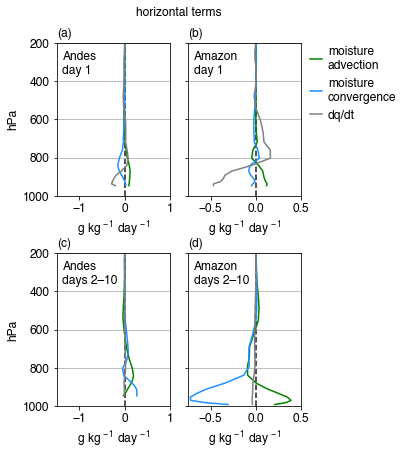

In [128]:
fontsize=12

fig = mp.figure(figsize=(4.5,6))

ax_list = []

#####
ax = fig.add_subplot(221)

ax.plot(diff_wet_region_horiz_adv_day1*1000.*86400.,ptot_400_wet_region_midpoints/100., c='green', label='moist. adv.')
ax.plot(diff_wet_region_horiz_conv_day1*1000.*86400.,ptot_400_wet_region_midpoints/100., c='dodgerblue', label='moist. conv.')
ax.plot(diff_wet_region_dqdt_day1*1000.*86400.,ptot_400_wet_region_midpoints/100., c='0.5', label='dq/dt')
ax.axvline(0, ls='--', c='0.1', zorder=1)
#ax.axhline(860, ls='--', c='0.1')
ax.set_ylim(1000,200)
ax.set_xlim(-1.5,1)
ax.tick_params(labelsize=fontsize)
ax.set_xlabel('g kg$^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)
ax.set_ylabel('hPa', fontsize=fontsize)
ax.text(s='Andes\nday 1', x=0.05, y=0.95, ha='left', va='top', transform=ax.transAxes, fontsize=fontsize)
ax.text(s='(a)', x=0, y=1.02, ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)
ax.yaxis.grid()
ax_list.append(ax)

#####
ax = fig.add_subplot(222)

ax.plot(diff_dry_region_horiz_adv_day1*1000.*86400.,ptot_400_wet_region_midpoints/100., c='green', label='moisture\nadvection')
ax.plot(diff_dry_region_horiz_conv_day1*1000.*86400.,ptot_400_wet_region_midpoints/100., c='dodgerblue', label='moisture\nconvergence')
ax.plot(diff_dry_region_dqdt_day1*1000.*86400.,ptot_400_wet_region_midpoints/100., c='0.5', label='dq/dt')
ax.axvline(0, ls='--', c='0.1', zorder=1)
#ax.axhline(860, ls='--', c='0.1')
ax.set_ylim(1000,200)
ax.set_xlim(-0.75,0.5)
ax.tick_params(labelsize=fontsize)
ax.set_xlabel('g kg$^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)
ax.set_yticklabels([])
ax_list.append(ax)
#ax.text(s='860\nhPa', x=0.3, y=860, ha='left', va='center', fontsize=fontsize)
ax.text(s='Amazon\nday 1', x=0.05, y=0.95, ha='left', va='top', transform=ax.transAxes, fontsize=fontsize)
ax.text(s='(b)', x=0, y=1.02, ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)
ax.yaxis.grid()

#####
ax = fig.add_subplot(223)

ax.plot(diff_wet_region_horiz_adv*1000.*86400.,ptot_400_wet_region_midpoints/100., c='green', label='moisture\nadvection')
ax.plot(diff_wet_region_horiz_conv*1000.*86400.,ptot_400_wet_region_midpoints/100.,c='dodgerblue', label='moisture\nconvergence')
ax.plot(diff_wet_region_dqdt*1000.*86400.,ptot_400_wet_region_midpoints/100.,c='0.5', label='dq/dt')
ax.axvline(0, ls='--', c='0.1', zorder=1)
#ax.axhline(860, ls='--', c='0.1')
ax.set_ylim(1000,200)
ax.set_xlim(-1.5,1)
ax.tick_params(labelsize=fontsize)
ax.set_xlabel('g kg$^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)
ax.set_ylabel('hPa', fontsize=fontsize)
ax.text(s='Andes\ndays 2–10', x=0.05, y=0.95, ha='left', va='top', transform=ax.transAxes, fontsize=fontsize)
ax.text(s='(c)', x=0, y=1.02, ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)
ax.yaxis.grid()
ax_list.append(ax)

#####
ax = fig.add_subplot(224)

ax.plot(diff_dry_region_horiz_adv*1000.*86400.,ptot_400_dry_region_midpoints/100., c='green', label='moisture\nadvection')
ax.plot(diff_dry_region_horiz_conv*1000.*86400.,ptot_400_dry_region_midpoints/100.,c='dodgerblue', label='moisture\nconvergence')
ax.plot(diff_dry_region_dqdt*1000.*86400.,ptot_400_dry_region_midpoints/100.,c='0.5',label='dq/dt')
ax.axvline(0, ls='--', c='0.1', zorder=1)
#ax.axhline(860, ls='--', c='0.1')
ax.set_ylim(1000,200)
ax.set_xlim(-0.75,0.5)
ax.tick_params(labelsize=fontsize)
ax.set_xlabel('g kg$^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)
ax.set_yticklabels([])
#ax.set_ylabel('hPa', fontsize=fontsize)
ax.text(s='Amazon\ndays 2–10', x=0.05, y=0.95, ha='left', va='top', transform=ax.transAxes, fontsize=fontsize)
#ax.text(s='860\nhPa', x=0.3, y=860, ha='left', va='center', fontsize=fontsize)
ax.text(s='(d)', x=0, y=1.02, ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)
ax.yaxis.grid()
ax_list.append(ax)

fig.tight_layout(h_pad=1)

handles, labels = ax_list[1].get_legend_handles_labels()
legend = ax_list[1].legend(handles, labels, fontsize=fontsize, bbox_to_anchor=(1.05,1), edgecolor='None', \
                   facecolor='None', fancybox=False, bbox_transform=ax_list[1].transAxes, loc='upper left', \
                   borderaxespad=0., borderpad=0.25, handlelength=1.0, handletextpad=0.5, \
                   columnspacing=0.5, markerscale=1)

axpos1 = ax_list[0].get_position()
axpos2 = ax_list[1].get_position()

fig.text(s='horizontal terms', x=0.5*(axpos1.x0+axpos2.x1), y=1.02, transform=fig.transFigure, ha='center', va='bottom', fontsize=fontsize)

fig.savefig('manuscript_figXX_mean_moisture_budget_HORIZONTAL_10d_and_day1.png', dpi=600, \
            transparent=True, bbox_inches='tight')

## plot omega vertical structure change

# lat subsets and latmeans

In [129]:
ptot_400_midpoints_lat_subset = ptot_400_midpoints[:,:,lat_indices_midpoints[:,0],:]
ptot_1000_midpoints_lat_subset = ptot_1000_midpoints[:,:,lat_indices_midpoints[:,0],:]

In [130]:
ptot_400_lat_subset = ptot_400[:,:,lat_indices[:,0],:]
ptot_1000_lat_subset = ptot_1000[:,:,lat_indices[:,0],:]

In [131]:
advection_400_lat_subset = advection_400[:,:,lat_indices_midpoints[:,0],:]
advection_1000_lat_subset = advection_1000[:,:,lat_indices_midpoints[:,0],:]

convergence_400_lat_subset = convergence_400[:,:,lat_indices_midpoints[:,0],:]
convergence_1000_lat_subset = convergence_1000[:,:,lat_indices_midpoints[:,0],:]

In [132]:
cont_adv_latmean = numpy.nanmean(advection_400_lat_subset, axis=2)
phys_adv_latmean = numpy.nanmean(advection_1000_lat_subset, axis=2)

cont_conv_latmean = numpy.nanmean(convergence_400_lat_subset, axis=2)
phys_conv_latmean = numpy.nanmean(convergence_1000_lat_subset, axis=2)

In [133]:
dqdt_400_lat_subset = dqdt_400[:,:,lat_indices_midpoints[:,0],:]
dqdt_1000_lat_subset = dqdt_1000[:,:,lat_indices_midpoints[:,0],:]

In [134]:
dqclouddt_400_lat_subset = dqclouddt_400[:,:,lat_indices_midpoints[:,0],:]
dqclouddt_1000_lat_subset = dqclouddt_1000[:,:,lat_indices_midpoints[:,0],:]

In [135]:
dqraindt_400_lat_subset = dqraindt_400[:,:,lat_indices_midpoints[:,0],:]
dqraindt_1000_lat_subset = dqraindt_1000[:,:,lat_indices_midpoints[:,0],:]

In [136]:
ptot_400_latmean = numpy.nanmean(ptot_400_lat_subset, axis=2)
ptot_1000_latmean = numpy.nanmean(ptot_1000_lat_subset, axis=2)

In [137]:
ptot_400_midpoints_latmean = numpy.nanmean(ptot_400_midpoints_lat_subset, axis=2)
ptot_1000_midpoints_latmean = numpy.nanmean(ptot_1000_midpoints_lat_subset, axis=2)

In [138]:
dqdt_400_latmean = numpy.nanmean(dqdt_400_lat_subset, axis=2)
dqdt_1000_latmean = numpy.nanmean(dqdt_1000_lat_subset, axis=2)

/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


In [139]:
dqclouddt_400_latmean = numpy.nanmean(dqclouddt_400_lat_subset, axis=2)
dqclouddt_1000_latmean = numpy.nanmean(dqclouddt_1000_lat_subset, axis=2)

/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


In [140]:
dqraindt_400_latmean = numpy.nanmean(dqraindt_400_lat_subset, axis=2)
dqraindt_1000_latmean = numpy.nanmean(dqraindt_1000_lat_subset, axis=2)

/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


In [141]:
ptot_400_midpoints_lat_subset = ptot_400_midpoints[:,:,lat_indices_midpoints[:,0],:]
ptot_400_midpoints_latmean = numpy.nanmean(ptot_400_midpoints_lat_subset, axis=2)

In [142]:
xx,zz=numpy.meshgrid(xlong[0,:],ptot_400[0,:,:,0].mean(axis=1))

In [143]:
diff_adv_latmean = phys_adv_latmean-cont_adv_latmean
diff_conv_latmean = phys_conv_latmean-cont_conv_latmean
diff_dqdt_latmean = dqdt_1000_latmean-dqdt_400_latmean
diff_dqclouddt_latmean = dqclouddt_1000_latmean-dqclouddt_400_latmean
diff_dqraindt_latmean = dqraindt_1000_latmean-dqraindt_400_latmean

In [144]:
wa_diffs_lat_subset = wa_diffs_landmask[:,:,lat_indices[:,0],:]
wa_diffs_latmean = numpy.nanmean(wa_diffs_lat_subset, axis=2)
wa_diffs_time_latmean = numpy.nanmean(wa_diffs_latmean[24:,:,:], axis=0)

/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


In [145]:
ptot_400_time_latmean = numpy.nanmean(ptot_400_latmean, axis=0)

# gridspec version of plot

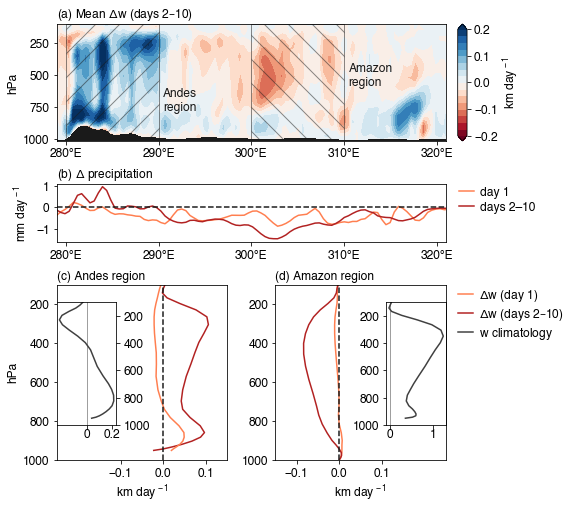

In [172]:
fontsize=12

fig = mp.figure(figsize=(6.5,7))
gs = matplotlib.gridspec.GridSpec(3,2,height_ratios=[2,1,3])

xticks_deg_E=numpy.array((280,290,300,310,320))
xticks = -(360-xticks_deg_E)
xticks_format=[str(tick)+DEGREE_SIGN+'E' for tick in xticks_deg_E]

ax_a = mp.subplot(gs[0,:])
ax_b = mp.subplot(gs[1,:])
ax_c = mp.subplot(gs[2,0])
ax_d = mp.subplot(gs[2,1])
#ax_e = mp.subplot(gs[3,0])
#ax_f = mp.subplot(gs[3,1])

ax_list = [ax_a,ax_b,ax_c,ax_d]#,ax_e,ax_f]


levels = numpy.arange(-.2,.21,0.025)
contour_plot = ax_a.contourf(xx+360., ptot_400_time_latmean/100., \
                           wa_diffs_time_latmean*86400./1000., \
                           levels=levels, \
                           cmap='RdBu', \
                           extend='both')
ax_a.tick_params(labelsize=fontsize)
ax_a.set_ylim(1013.25,100)
ax_a.set_xlim(279,321)
ax_a.text(s='(a) Mean $\Delta w$ (days 2–10)',\
       x=0, y=1.01, \
       ha='left', va='bottom', \
       fontsize=fontsize, \
       transform=ax_a.transAxes)
ax_a.set_xticks(xticks_deg_E)
ax_a.set_xticklabels(xticks_format)
ax_a.set_ylabel('hPa', fontsize=fontsize)
ax_a.set_facecolor('0.1')
ax_a.fill_between(x=[wet_lon_lo_degE,wet_lon_hi_degE], y1=ax_a.get_ylim()[0], y2=ax_a.get_ylim()[1],\
                  facecolor='None', edgecolor='0.1',
                  hatch='/', alpha=0.5)
ax_a.fill_between(x=[dry_lon_lo_degE,dry_lon_hi_degE], y1=ax_a.get_ylim()[0], y2=ax_a.get_ylim()[1],\
                  facecolor='None', edgecolor='0.1',
                  hatch='\\', alpha=0.5)
ax_a.text(s='Andes\nregion',x=wet_lon_hi_degE+0.5, y=600, ha='left',va='top',fontsize=fontsize,color='0.1')
ax_a.text(s='Amazon\nregion',x=dry_lon_hi_degE+0.5, y=400, ha='left',va='top',fontsize=fontsize,color='0.1')


ax_b.plot(360+xlong[0,:],pandas.Series(raintot_diffs_latmean_day1*24).rolling(window=3, center=True).mean().values, c='coral', label='day 1')
ax_b.plot(360+xlong[0,:],pandas.Series(raintot_diffs_latmean_day2_10*24).rolling(window=3, center=True).mean().values, c='firebrick', label='days 2–10')
ax_b.axhline(0, c='0.1', ls='--')
ax_b.set_xlim(279,321)
ax_b.set_ylim(-1.6,1.1)
ax_b.set_yticks([-1,0,1])
ax_b.set_xticks(xticks_deg_E)
ax_b.set_xticklabels(xticks_format)
ax_b.tick_params(labelsize=fontsize)
ax_b.text(s='(b) $\Delta$ precipitation',\
       x=0, y=1.01, \
       ha='left', va='bottom', \
       fontsize=fontsize, \
       transform=ax_b.transAxes)
ax_b.set_ylabel('mm day$^{\,-1}$', fontsize=fontsize)

ax=ax_c
ax.plot(wa_diff_wet_region*86400./1000.,ptot_400_wet_region/100., c='firebrick')
ax.plot(wa_diff_wet_region_day1*86400./1000.,ptot_400_wet_region/100., c='coral')
ax.axvline(0, ls='--', c='0.1')
ax.set_ylim(1000,100)
ax.set_xlim(-.25,.15)
ax.tick_params(labelsize=fontsize)
ax.set_xlabel('km day$^{\,-1}$', fontsize=fontsize)
ax.set_ylabel('hPa', fontsize=fontsize)
ax.text(s='(c) Andes region', x=0., y=1.01, ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)
#ax.text(s='Andes', x=0.97, y=0.97, ha='right', va='top', transform=ax.transAxes, fontsize=fontsize)
ax.set_yticks(numpy.arange(1000,99,-200))
ax.set_xticks([-.1,0,.1])

ax=ax_d
ax.plot(wa_diff_dry_region_day1*86400/1000.,ptot_400_dry_region/100., c='coral', label='$\Delta w$ (day 1)')
ax.plot(wa_diff_dry_region*86400/1000.,ptot_400_dry_region/100., c='firebrick', label='$\Delta w$ (days 2–10)')
ax.axvline(0, ls='--', c='0.1')
#ax.axhline(860, ls='--', c='0.1')
ax.set_ylim(1000,100)
ax.set_xlim(-.15,.25)
ax.tick_params(labelsize=fontsize)
ax.set_xlabel('km day$^{\,-1}$', fontsize=fontsize)
#ax.set_ylabel('hPa', fontsize=fontsize)
ax.text(s='(d) Amazon region', x=0., y=1.01, ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)
#ax.text(s='Amazon', x=0.97, y=0.97, ha='right', va='top', transform=ax.transAxes, fontsize=fontsize)
ax.set_yticks(numpy.arange(1000,99,-200))
ax.set_xticks([-.1,0,.1])

fig.tight_layout(h_pad=2)

ax_pos = ax_a.get_position()
cbar_ax = fig.add_axes([ax_pos.x1+0.025, ax_pos.y0, 0.02, ax_pos.height])
cbar = fig.colorbar(contour_plot, cax=cbar_ax)
cbar_ax.tick_params(labelsize=fontsize)
cbar.set_label('km day$^{\,-1}$', fontsize=fontsize)
cbar.set_ticks(levels[0::4])

handles, labels = ax_b.get_legend_handles_labels()
ax_b.legend(handles, labels, fontsize=fontsize, scatterpoints=1, bbox_to_anchor=(1.025,1.), \
            bbox_transform=ax_b.transAxes, loc='upper left', borderaxespad=0, labelspacing=0.25, \
            fancybox=False, edgecolor='0', framealpha=0, borderpad=0.25, \
            handletextpad=0.5, markerscale=1, handlelength=1.25)

ax_pos = ax_c.get_position()
ax_c_in = fig.add_axes([ax_pos.x0,ax_pos.y0+0.2*ax_pos.height,0.35*ax_pos.width,0.7*ax_pos.height])#, frameon=False)
ax_c_in.plot(wa_400_dry*86400./1000.,ptot_400_wet_region/100., c='0.25', label='10d mean')
ax_c_in.tick_params(labelsize=fontsize)
ax_c_in.tick_params(axis='x', pad=0)
ax_c_in.set_ylim(1000,100)
ax_c_in.yaxis.tick_right()
ax_c_in.axvline(0, lw=0.5, color='0.25', ls='-')
ax_c_in.set_xticks([0.,.2])
ax_c_in.set_xticklabels(['0','0.2'])
#ax_c_in.set_xlabel('mm day$^{\,-1}$', fontsize=fontsize)
#ax_c_in.text(s='$w$ clim.', x=1., y=1.02, ha='right', va='bottom', transform=ax_c_in.transAxes, fontsize=fontsize)

ax_pos = ax_d.get_position()
ax_d_in = fig.add_axes([ax_pos.x0+ax_pos.width*0.65,ax_pos.y0+0.2*ax_pos.height,0.35*ax_pos.width,0.7*ax_pos.height])#, frameon=False)
ax_d_in.plot(wa_400_wet*86400./1000.,ptot_400_wet_region/100., c='0.25', label='$w$ climatology')
ax_d_in.tick_params(labelsize=fontsize)
ax_d_in.tick_params(axis='x', pad=0)
ax_d_in.set_ylim(1000,100)
#ax_d_in.set_xlabel('mm day$^{\,-1}$', fontsize=fontsize)
#ax_d_in.text(s='$w$ clim.', x=0, y=1.02, ha='left', va='bottom', transform=ax_d_in.transAxes, fontsize=fontsize, label='$w$ clim.\n(days 2–10)')
ax_d_in.axvline(0, lw=0.5, color='0.25', ls='-')


h_out, l_out=ax_d.get_legend_handles_labels()
h_in, l_in = ax_d_in.get_legend_handles_labels()
ax_d.legend(h_out+h_in, l_out+l_in, fontsize=fontsize, scatterpoints=1, bbox_to_anchor=(1.05,1.), \
            bbox_transform=ax_d.transAxes, loc='upper left', borderaxespad=0, labelspacing=0.25, \
            fancybox=False, edgecolor='0', framealpha=0, borderpad=0.25, \
            handletextpad=0.5, markerscale=1, handlelength=1.25)

fig.savefig('manuscript_fig4_winds_precip.png', dpi=600, bbox_inches='tight')


# Plot dqdt and moisture convergence in lat means

In [173]:
dqdt_diff_latmean = dqdt_1000_latmean - dqdt_400_latmean

In [174]:
xx_midpoints = 0.5*(xx[1:,1:]+xx[:-1,:-1])

ptot_400_time_latmean_midpoints = 0.5*(ptot_400_time_latmean[1:,1:]+\
                                       ptot_400_time_latmean[:-1,:-1])

# dqdt and convergence terms on day 1

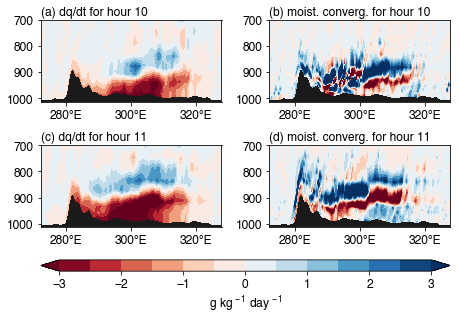

In [175]:
fontsize=12

xlong_min = -154.76123
xlong_max = -25.238678

levels = numpy.arange(-3,3.1,0.5)

fig = mp.figure(figsize=(6.5,3.5))

xticks_deg_E=numpy.array((280,300,320))
xticks = -(360-xticks_deg_E)
xticks_format=[str(tick)+DEGREE_SIGN+'E' for tick in xticks_deg_E]

ax_list = []

hour1 = 13
hour1_string = hour1-4+1

hour2 = 14
hour2_string = hour2-4+1

ax = fig.add_subplot(221)
contour_plot = ax.contourf(xx_midpoints+360., \
                           ptot_400_time_latmean_midpoints/100., \
                           dqdt_diff_latmean[hour1,:,:]*86400.*1000., cmap='RdBu',\
                           levels=levels, extend='both')

ax.set_ylim(1013.25,700)
ax.set_xticks([280,300,320])
ax.set_xlim(xlong_min+67.+360.,xlong_max+360.-7)
ax.set_xticklabels(xticks_format)
ax.set_facecolor('0.1')
ax.tick_params(labelsize=fontsize)
ax.set_yticks([700,800,900,1000])
ax.text(s='(a) dq/dt for hour '+'{:02d}'.format(hour1_string), x=0, y=1.02, \
        ha='left', va='bottom', \
        transform=ax.transAxes, fontsize=fontsize)
#mp.colorbar(contour_plot)
ax_list.append(ax)

ax = fig.add_subplot(222)
contour_plot = ax.contourf(xx_midpoints+360., \
                           ptot_400_time_latmean_midpoints/100., \
                           diff_conv_latmean[hour1,:,:]*86400.*1000., cmap='RdBu', \
                           levels=levels, extend='both')

ax.set_ylim(1013.25,700)
ax.set_xticks([280,300,320])
ax.set_xlim(xlong_min+67.+360.,xlong_max+360.-7)
ax.set_xticklabels(xticks_format)
ax.set_facecolor('0.1')
ax.tick_params(labelsize=fontsize)
ax.set_yticks([700,800,900,1000])
ax.text(s='(b) moist. converg. for hour '+'{:02d}'.format(hour1_string), x=0, y=1.02, \
        ha='left', va='bottom', \
        transform=ax.transAxes, fontsize=fontsize)
#mp.colorbar(contour_plot)
ax_list.append(ax)

ax = fig.add_subplot(223)
contour_plot = ax.contourf(xx_midpoints+360., \
                           ptot_400_time_latmean_midpoints/100., \
                           dqdt_diff_latmean[hour2,:,:]*86400.*1000., cmap='RdBu', \
                           levels=levels, extend='both')

ax.set_ylim(1013.25,700)
ax.set_xticks([280,300,320])
ax.set_xlim(xlong_min+67.+360.,xlong_max+360.-7)
ax.set_xticklabels(xticks_format)
ax.set_facecolor('0.1')
ax.tick_params(labelsize=fontsize)
ax.set_yticks([700,800,900,1000])
ax.text(s='(c) dq/dt for hour '+'{:02d}'.format(hour2_string), x=0, y=1.02, \
        ha='left', va='bottom', \
        transform=ax.transAxes, fontsize=fontsize)
ax_list.append(ax)

ax = fig.add_subplot(224)
contour_plot = ax.contourf(xx_midpoints+360., \
                           ptot_400_time_latmean_midpoints/100., \
                           diff_conv_latmean[hour2,:,:]*86400.*1000., cmap='RdBu', \
                           levels=levels, extend='both')

ax.set_ylim(1013.25,700)
ax.set_xticks([280,300,320])
ax.set_xlim(xlong_min+67.+360.,xlong_max+360.-7)
ax.set_xticklabels(xticks_format)
ax.set_facecolor('0.1')
ax.tick_params(labelsize=fontsize)
ax.set_yticks([700,800,900,1000])
ax.text(s='(d) moist. converg. for hour '+'{:02d}'.format(hour2_string), x=0, y=1.02, \
        ha='left', va='bottom', \
        transform=ax.transAxes, fontsize=fontsize)
#mp.colorbar(contour_plot)
ax_list.append(ax)

fig.tight_layout(h_pad=2)

axpos_bl = ax_list[2].get_position()
axpos_br = ax_list[3].get_position()

cbar_ax = fig.add_axes([axpos_bl.x0, axpos_bl.y0-0.175, axpos_br.x1-axpos_bl.x0, 0.045])
cbar = fig.colorbar(contour_plot, cax=cbar_ax, orientation='horizontal')
cbar_ax.tick_params(labelsize=fontsize)
cbar.set_label('g kg$^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)

fig.savefig('dqdt_and_q_convergence_hours_'+\
            '{:02d}'.format(hour1_string)+\
            'and'+'{:02d}'.format(hour2_string)+'.png',\
            dpi=600, bbox_inches='tight')

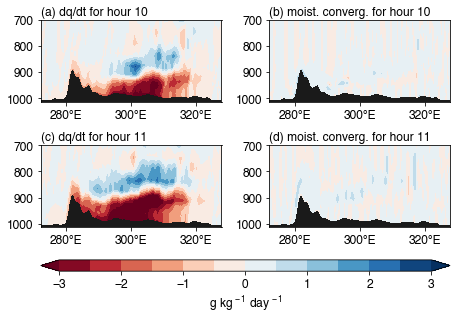

In [176]:
fontsize=12

xlong_min = -154.76123
xlong_max = -25.238678

levels = numpy.arange(-3,3.1,0.5)

fig = mp.figure(figsize=(6.5,3.5))

xticks_deg_E=numpy.array((280,300,320))
xticks = -(360-xticks_deg_E)
xticks_format=[str(tick)+DEGREE_SIGN+'E' for tick in xticks_deg_E]

ax_list = []

hour1 = 13
hour1_string = hour1-4+1

hour2 = 14
hour2_string = hour2-4+1

ax = fig.add_subplot(221)
contour_plot = ax.contourf(xx_midpoints+360., \
                           ptot_400_time_latmean_midpoints/100., \
                           dqdt_diff_latmean[hour1,:,:]*86400.*1000., cmap='RdBu',\
                           levels=levels, extend='both')

ax.set_ylim(1013.25,700)
ax.set_xticks([280,300,320])
ax.set_xlim(xlong_min+67.+360.,xlong_max+360.-7)
ax.set_xticklabels(xticks_format)
ax.set_facecolor('0.1')
ax.tick_params(labelsize=fontsize)
ax.set_yticks([700,800,900,1000])
ax.text(s='(a) dq/dt for hour '+'{:02d}'.format(hour1_string), x=0, y=1.02, \
        ha='left', va='bottom', \
        transform=ax.transAxes, fontsize=fontsize)
#mp.colorbar(contour_plot)
ax_list.append(ax)

ax = fig.add_subplot(222)
contour_plot = ax.contourf(xx_midpoints+360., \
                           ptot_400_time_latmean_midpoints/100., \
                           diff_adv_latmean[hour1,:,:]*86400.*1000., cmap='RdBu', \
                           levels=levels, extend='both')

ax.set_ylim(1013.25,700)
ax.set_xticks([280,300,320])
ax.set_xlim(xlong_min+67.+360.,xlong_max+360.-7)
ax.set_xticklabels(xticks_format)
ax.set_facecolor('0.1')
ax.tick_params(labelsize=fontsize)
ax.set_yticks([700,800,900,1000])
ax.text(s='(b) moist. converg. for hour '+'{:02d}'.format(hour1_string), x=0, y=1.02, \
        ha='left', va='bottom', \
        transform=ax.transAxes, fontsize=fontsize)
#mp.colorbar(contour_plot)
ax_list.append(ax)

ax = fig.add_subplot(223)
contour_plot = ax.contourf(xx_midpoints+360., \
                           ptot_400_time_latmean_midpoints/100., \
                           dqdt_diff_latmean[hour2,:,:]*86400.*1000., cmap='RdBu', \
                           levels=levels, extend='both')

ax.set_ylim(1013.25,700)
ax.set_xticks([280,300,320])
ax.set_xlim(xlong_min+67.+360.,xlong_max+360.-7)
ax.set_xticklabels(xticks_format)
ax.set_facecolor('0.1')
ax.tick_params(labelsize=fontsize)
ax.set_yticks([700,800,900,1000])
ax.text(s='(c) dq/dt for hour '+'{:02d}'.format(hour2_string), x=0, y=1.02, \
        ha='left', va='bottom', \
        transform=ax.transAxes, fontsize=fontsize)
ax_list.append(ax)

ax = fig.add_subplot(224)
contour_plot = ax.contourf(xx_midpoints+360., \
                           ptot_400_time_latmean_midpoints/100., \
                           diff_adv_latmean[hour2,:,:]*86400.*1000., cmap='RdBu', \
                           levels=levels, extend='both')

ax.set_ylim(1013.25,700)
ax.set_xticks([280,300,320])
ax.set_xlim(xlong_min+67.+360.,xlong_max+360.-7)
ax.set_xticklabels(xticks_format)
ax.set_facecolor('0.1')
ax.tick_params(labelsize=fontsize)
ax.set_yticks([700,800,900,1000])
ax.text(s='(d) moist. converg. for hour '+'{:02d}'.format(hour2_string), x=0, y=1.02, \
        ha='left', va='bottom', \
        transform=ax.transAxes, fontsize=fontsize)
#mp.colorbar(contour_plot)
ax_list.append(ax)

fig.tight_layout(h_pad=2)

axpos_bl = ax_list[2].get_position()
axpos_br = ax_list[3].get_position()

cbar_ax = fig.add_axes([axpos_bl.x0, axpos_bl.y0-0.175, axpos_br.x1-axpos_bl.x0, 0.045])
cbar = fig.colorbar(contour_plot, cax=cbar_ax, orientation='horizontal')
cbar_ax.tick_params(labelsize=fontsize)
cbar.set_label('g kg$^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)

fig.savefig('dqdt_and_q_advection_hours_'+\
            '{:02d}'.format(hour1_string)+\
            'and'+'{:02d}'.format(hour2_string)+'.png',\
            dpi=600, bbox_inches='tight')

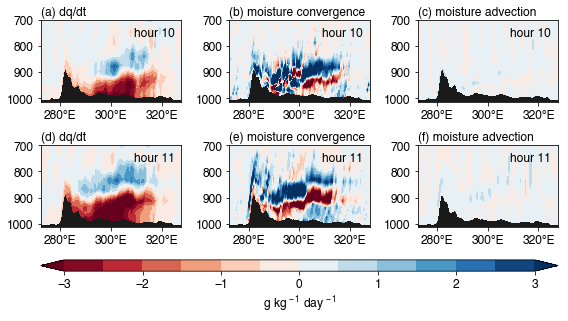

In [177]:
fontsize=12

xlong_min = -154.76123
xlong_max = -25.238678

levels = numpy.arange(-3,3.1,0.5)

fig = mp.figure(figsize=(8,3.5))

xticks_deg_E=numpy.array((280,300,320))
xticks = -(360-xticks_deg_E)
xticks_format=[str(tick)+DEGREE_SIGN+'E' for tick in xticks_deg_E]

ax_list = []

hour1 = 13
hour1_string = hour1-4+1

hour2 = 14
hour2_string = hour2-4+1

ax = fig.add_subplot(231)
contour_plot = ax.contourf(xx_midpoints+360., \
                           ptot_400_time_latmean_midpoints/100., \
                           dqdt_diff_latmean[hour1,:,:]*86400.*1000., cmap='RdBu',\
                           levels=levels, extend='both')

ax.set_ylim(1013.25,700)
ax.set_xticks([280,300,320])
ax.set_xlim(xlong_min+67.+360.,xlong_max+360.-7)
ax.set_xticklabels(xticks_format)
ax.set_facecolor('0.1')
ax.tick_params(labelsize=fontsize)
ax.set_yticks([700,800,900,1000])
ax.text(s='(a) dq/dt', x=0, y=1.02, \
        ha='left', va='bottom', \
        transform=ax.transAxes, fontsize=fontsize)
ax.text(s='hour '+'{:02d}'.format(hour1_string), x=0.95, y=0.91, \
        ha='right', va='top', \
        transform=ax.transAxes, fontsize=fontsize)
#mp.colorbar(contour_plot)
ax_list.append(ax)

ax = fig.add_subplot(232)
contour_plot = ax.contourf(xx_midpoints+360., \
                           ptot_400_time_latmean_midpoints/100., \
                           diff_conv_latmean[hour1,:,:]*86400.*1000., cmap='RdBu', \
                           levels=levels, extend='both')

ax.set_ylim(1013.25,700)
ax.set_xticks([280,300,320])
ax.set_xlim(xlong_min+67.+360.,xlong_max+360.-7)
ax.set_xticklabels(xticks_format)
ax.set_facecolor('0.1')
ax.tick_params(labelsize=fontsize)
ax.set_yticks([700,800,900,1000])
ax.text(s='(b) moisture convergence', x=0, y=1.02, \
        ha='left', va='bottom', \
        transform=ax.transAxes, fontsize=fontsize)
ax.text(s='hour '+'{:02d}'.format(hour1_string), x=0.95, y=0.91, \
        ha='right', va='top', \
        transform=ax.transAxes, fontsize=fontsize)
#mp.colorbar(contour_plot)
ax_list.append(ax)



ax = fig.add_subplot(233)
contour_plot = ax.contourf(xx_midpoints+360., \
                           ptot_400_time_latmean_midpoints/100., \
                           diff_adv_latmean[hour1,:,:]*86400.*1000., cmap='RdBu', \
                           levels=levels, extend='both')

ax.set_ylim(1013.25,700)
ax.set_xticks([280,300,320])
ax.set_xlim(xlong_min+67.+360.,xlong_max+360.-7)
ax.set_xticklabels(xticks_format)
ax.set_facecolor('0.1')
ax.tick_params(labelsize=fontsize)
ax.set_yticks([700,800,900,1000])
ax.text(s='(c) moisture advection', x=0, y=1.02, \
        ha='left', va='bottom', \
        transform=ax.transAxes, fontsize=fontsize)
ax.text(s='hour '+'{:02d}'.format(hour1_string), x=0.95, y=0.91, \
        ha='right', va='top', \
        transform=ax.transAxes, fontsize=fontsize)
#mp.colorbar(contour_plot)
ax_list.append(ax)





ax = fig.add_subplot(234)
contour_plot = ax.contourf(xx_midpoints+360., \
                           ptot_400_time_latmean_midpoints/100., \
                           dqdt_diff_latmean[hour2,:,:]*86400.*1000., cmap='RdBu', \
                           levels=levels, extend='both')

ax.set_ylim(1013.25,700)
ax.set_xticks([280,300,320])
ax.set_xlim(xlong_min+67.+360.,xlong_max+360.-7)
ax.set_xticklabels(xticks_format)
ax.set_facecolor('0.1')
ax.tick_params(labelsize=fontsize)
ax.set_yticks([700,800,900,1000])
ax.text(s='(d) dq/dt', x=0, y=1.02, \
        ha='left', va='bottom', \
        transform=ax.transAxes, fontsize=fontsize)
ax.text(s='hour '+'{:02d}'.format(hour2_string), x=0.95, y=0.91, \
        ha='right', va='top', \
        transform=ax.transAxes, fontsize=fontsize)
ax_list.append(ax)


ax = fig.add_subplot(235)
contour_plot = ax.contourf(xx_midpoints+360., \
                           ptot_400_time_latmean_midpoints/100., \
                           diff_conv_latmean[hour2,:,:]*86400.*1000., cmap='RdBu', \
                           levels=levels, extend='both')

ax.set_ylim(1013.25,700)
ax.set_xticks([280,300,320])
ax.set_xlim(xlong_min+67.+360.,xlong_max+360.-7)
ax.set_xticklabels(xticks_format)
ax.set_facecolor('0.1')
ax.tick_params(labelsize=fontsize)
ax.set_yticks([700,800,900,1000])
ax.text(s='(e) moisture convergence', x=0, y=1.02, \
        ha='left', va='bottom', \
        transform=ax.transAxes, fontsize=fontsize)
ax.text(s='hour '+'{:02d}'.format(hour2_string), x=0.95, y=0.91, \
        ha='right', va='top', \
        transform=ax.transAxes, fontsize=fontsize)
#mp.colorbar(contour_plot)
ax_list.append(ax)


ax = fig.add_subplot(236)
contour_plot = ax.contourf(xx_midpoints+360., \
                           ptot_400_time_latmean_midpoints/100., \
                           diff_adv_latmean[hour2,:,:]*86400.*1000., cmap='RdBu', \
                           levels=levels, extend='both')

ax.set_ylim(1013.25,700)
ax.set_xticks([280,300,320])
ax.set_xlim(xlong_min+67.+360.,xlong_max+360.-7)
ax.set_xticklabels(xticks_format)
ax.set_facecolor('0.1')
ax.tick_params(labelsize=fontsize)
ax.set_yticks([700,800,900,1000])
ax.text(s='(f) moisture advection', x=0, y=1.02, \
        ha='left', va='bottom', \
        transform=ax.transAxes, fontsize=fontsize)
ax.text(s='hour '+'{:02d}'.format(hour2_string), x=0.95, y=0.91, \
        ha='right', va='top', \
        transform=ax.transAxes, fontsize=fontsize)
#mp.colorbar(contour_plot)
ax_list.append(ax)


fig.tight_layout(h_pad=2)

axpos_bl = ax_list[3].get_position()
axpos_br = ax_list[5].get_position()

cbar_ax = fig.add_axes([axpos_bl.x0, axpos_bl.y0-0.175, axpos_br.x1-axpos_bl.x0, 0.045])
cbar = fig.colorbar(contour_plot, cax=cbar_ax, orientation='horizontal')
cbar_ax.tick_params(labelsize=fontsize)
cbar.set_label('g kg$^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)

fig.savefig('dqdt_and_q_convergence_and_advection_hours_'+\
            '{:02d}'.format(hour1_string)+\
            'and'+'{:02d}'.format(hour2_string)+'.png',\
            dpi=600, bbox_inches='tight')